In [86]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)
import sys
from pylab import *
import os
import urllib.request
import itertools
import numpy as np
from adjustText import adjust_text

In [87]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', None)

pd.options.mode.chained_assignment = None

In [88]:
COLORS = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}

In [89]:
YEAR = 2020
data = pd.read_csv('https://github.com/guga31bb/nflfastR-data/blob/master/data/' \
                         'play_by_play_' + str(YEAR) + '.csv.gz?raw=True',
                         compression='gzip', low_memory=False)

In [90]:
#remove deprecated columns
data.drop(['passer_player_name', 'passer_player_id',
           'rusher_player_name', 'rusher_player_id',
           'receiver_player_name', 'receiver_player_id'],
          axis=1, inplace=True)

In [91]:
#remove plays that are not penalties, passes, or runs or have null epa
data = data.loc[(data.play_type.isin(['no_play','pass','run'])) & (data.epa.isna()==False)]

In [92]:
#make sure QB scrambles are labeled appropriately
data.play_type.loc[data['pass']==1] = 'pass'
data.play_type.loc[data.rush==1] = 'run'

In [93]:
#clean up index after data clean up
data.reset_index(drop=True, inplace=True)

In [94]:
#get current week for qualifying data
currentweek = data['week'].max()
#qualifying number of plays
qualify_val = currentweek*20

In [95]:
#group by without making it the index!
qbs = data.groupby(['passer', 'posteam'], as_index=False).agg({'qb_epa':'mean',
                                                               'cpoe':'mean',
                                                               'play_id':'count'})

In [96]:
qbs.sort_values('qb_epa', ascending=False, inplace=True)

#round data!
qbs = qbs.round(4)

#rename columns easily!
qbs.columns = ['Player', 'Team', 'EPA per Dropback', 'CPOE', 'Dropbacks']

In [97]:
#filter qbs to qualifiers
qbs = qbs.loc[(qbs['Dropbacks'] > (qualify_val))]

In [98]:
#get baseline EPA+ - 100
avg = qbs['EPA per Dropback'].mean()

In [99]:
#set EPA+ for qualifying QBs
qbs['EPA+'] = round(qbs['EPA per Dropback']/avg, 2) * 100
#qbs['EPA+']

In [100]:
#Add team colors to dataframe
#maps using Team abbrev matching dict key
qbs['color'] = qbs['Team'].map(COLORS)
#qbs

In [102]:
#hacky function for placing values on the chart without overlapping bars
def numplacement(val):
    if val < -99:
        return val - 20
    if val < -9:
        return val - 15
    if val < 0:
        return val - 10
    else:
        return val + 3

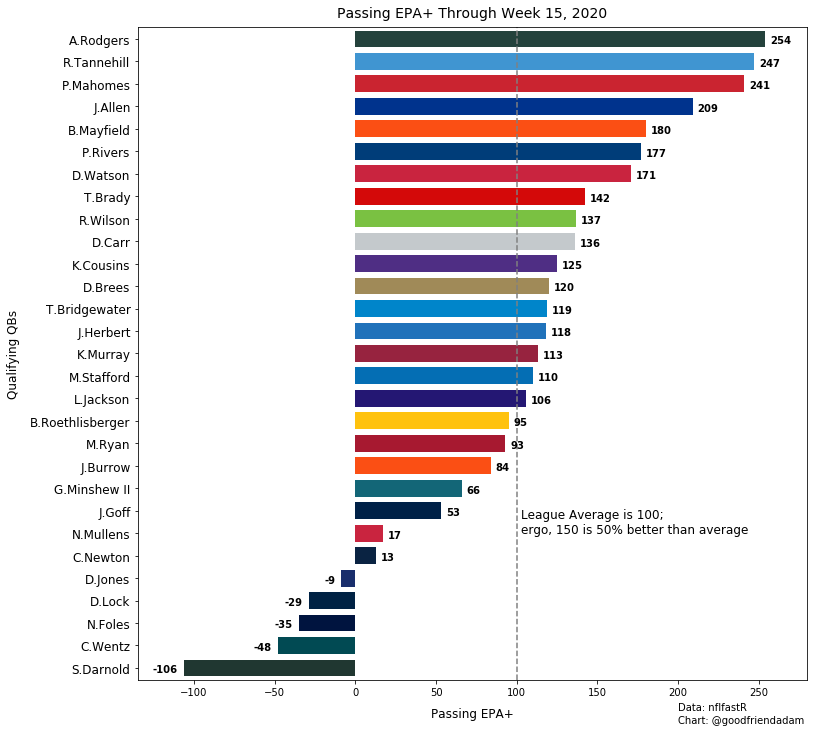

In [114]:
numqbs = len(qbs)
fig, ax = plt.subplots(figsize=(12,12))

#sort by feistyness
qbs = qbs.sort_values(by='EPA+', ascending=True)

#create bar chart, setting colors for each bar
ax.barh(np.arange(0, numqbs), qbs['EPA+'], color=qbs.color, height= .75)

#label bars
for y, x in enumerate(qbs['EPA+']):
    ax.text(numplacement(x), y-.2, int(round(x, 2)), color='black', fontweight='bold')

#show league average EPA+ (100)
ax.axvline(x=100, linestyle='--', color='grey')
#League average line label
leagueAvgDisclaimer= 'League Average of Qualifying QBs is 100; \nergo, 150 is 50% better than average';
plt.text(102.5, 6, leagueAvgDisclaimer, fontsize=12)
#plt.text(102.5, 5.25,'Ergo, 150 is 50% better than average',fontsize=12)

#set margins on plot
plt.margins(y=.005)

#add grid
#ax.grid(zorder=0, alpha=.6, axis='y')
#ax.set_axisbelow(True)

#Set y axis ticks and labels abbreviations
ax.set_yticks(np.arange(0,numqbs))
ax.set_yticklabels(qbs.Player,fontsize=12)
ax.set_ylabel('Qualifying QBs',fontsize=12,labelpad=10)

#set xlim and label
ax.set_xlim(-135, 280)
ax.set_xlabel('Passing EPA+', fontsize=12, labelpad=10)

#set title and sources
ax.set_title('Passing EPA+ Through Week 15, 2020', fontsize=14, pad=10)
plt.figtext(.75, 0.09,'Data: nflfastR',fontsize=10)
plt.figtext(.75, 0.075,'Chart: @goodfriendadam',fontsize=10)

#save chart
plt.savefig(os.getcwd() + '\\output\\EPA+2020.png',dpi=400)

In [ ]:
#cols = data.columns.tolist()
#cols